## Setup
### Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import pycountry
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import seaborn as sns
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from statsmodels.tsa.vector_ar.dynamic import DynamicPanelVAR
%run ../src/models/geo_helpers.py
%run ../src/models/section_series.py
%load_ext rpy2.ipython
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format
plt.style.use('seaborn-colorblind')

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load Data

In [2]:
panel_df = pd.read_csv('../data/processed/section_series_sum_small/panel.csv', index_col=['city','year'])
panel = xr.Dataset.from_dataframe(panel_df)

## Modeling
### VAR Meta Model
Run a vector autoregression for every city with 3 lags, estimating the impact of the earthquake dummy.

In [3]:
%%R
library('dynlm')
library('vars')
library('dplyr')

/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: zoo

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘zoo’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: MASS

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: strucchange

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: sandwich

  warnings.warn(x, RRuntimeWarning

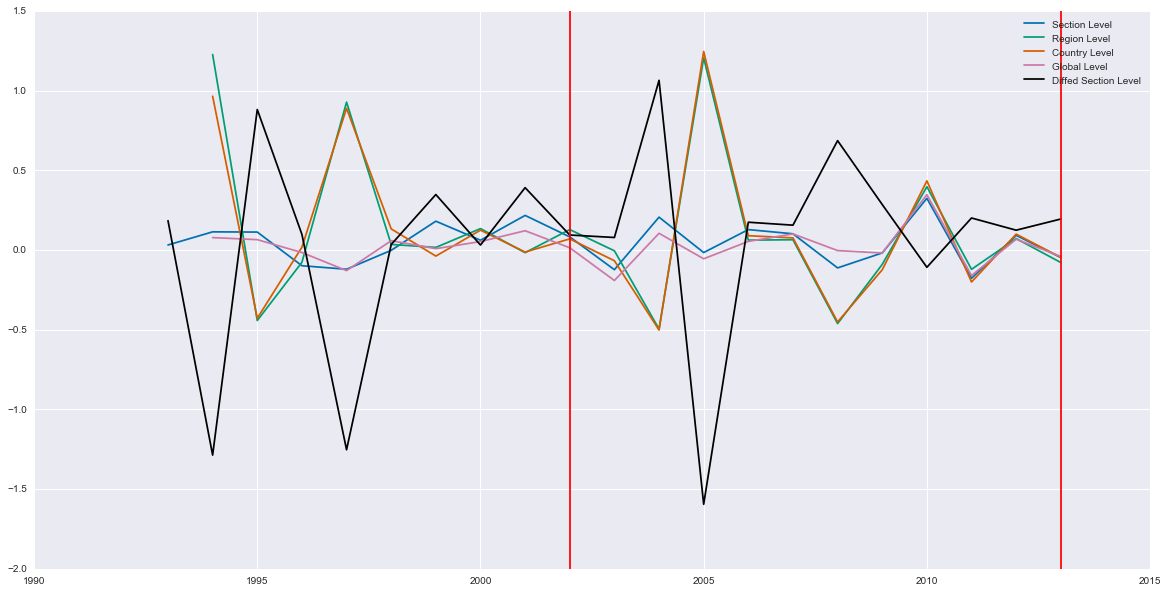

In [4]:
df = panel.sel(city='bushehr').to_dataframe().fillna(0).drop(['city','latitude','longitude'],axis=1)
pca_pct_change_balancer = pd.DataFrame(
    PCA().fit_transform(df[['region_sum_lum','country_sum_lum','global_sum_lum']]
                        .pct_change()
                        .replace([np.inf, -np.inf], np.nan)
                        .fillna(0))[:,:1],
    index=df.index).sum(axis=1)

plt.figure(figsize=(20,10))
plt.plot(df.sum_lum.pct_change(), label='Section Level')
plt.plot(df.region_sum_lum.pct_change(), label='Region Level')
plt.plot(df.country_sum_lum.pct_change(), label='Country Level')
plt.plot(df.global_sum_lum.pct_change(), label='Global Level')
plt.plot(df.sum_lum.pct_change() - pca_pct_change_balancer, label='Diffed Section Level', c='black')
for i, row in df[df['earthquake_dummy'] == True].iterrows():
    plt.axvline(x=row.name, c='r')
plt.legend()
plt.show()

In [5]:
r_panel = panel_df.reset_index().dropna(axis=0)

In [6]:
%%R -i df
get_balancer <- function(df){
    components = c(2,3)
    sum_lum_mt <- df[c('sum_lum','region_sum_lum','country_sum_lum','global_sum_lum')]
    sum_lum_mt <- data.matrix(sum_lum_mt)
    sum_lum_mt <- diff(sum_lum_mt) / sum_lum_mt[-nrow(sum_lum_mt),]
    sum_lum_mt[is.na(sum_lum_mt)] <- 0
    sum_lum_mt[is.infinite(sum_lum_mt)] <- 0
    pca_balancer <- prcomp(t(sum_lum_mt[,c('region_sum_lum','country_sum_lum','global_sum_lum')]), center=TRUE, scale.=TRUE, retx=TRUE)
    rowSums(pca_balancer$rotation[,components])
}
make_pct_change <- function(df){
    for (c in colnames(df)){
        df[c] <- diff(df[c]) / df[c][-nrow(df)]
        df[c][is.na(df[c])] <- 0
        df[c][is.infinite(df[c])] <- 0
    }
    df
}

In [7]:
%%R -i r_panel -o results
cities <- unique(r_panel$city)
results <- data.frame('city'=c(0),'el1'=c(0),'el2'=c(0),'el3'=c(0))

for (city in cities){
    lags = 3
    data <- r_panel[r_panel$city == city,][-lags]
    balancer <- get_balancer(data)
    city_data <- data.frame(diff(as.matrix(data[,c('inflation','imports','exports')])))
    city_data$earthquake_dummy <- as.numeric(data$earthquake_dummy[-1])
    city_data$balanced_sum_lum <- diff(data$sum_lum) / data$sum_lum[-nrow(data)]
    city_data$balanced_sum_lum[is.na(city_data$balanced_sum_lum)] <- 0
    city_data$balanced_sum_lum[is.infinite(city_data$balanced_sum_lum)] <- 0
    var <- VAR(city_data, p=lags)
    result <- data.frame(
        'city'= c(city),
        'el1'= c(var$varresult$balanced_sum_lum$coefficients['balanced_sum_lum.l1']),
        'el3'= c(var$varresult$balanced_sum_lum$coefficients['balanced_sum_lum.l3']),
        'el2'= c(var$varresult$balanced_sum_lum$coefficients['balanced_sum_lum.l2'])
    )
    results <- rbind(results,result)
}
rownames(results) <- results$city
results <- results[c('el1','el2','el3')]

In [8]:
filtered_results = results.dropna(axis=0)
filtered_results.head()

/usr/local/lib/python3.5/site-packages/pandas/types/missing.py:147: RuntimeWarning: invalid value encountered in isnan
  result = np.isnan(values)


,el1,el2,el3
0,0.0000,0.0000,0.0000
aberdeen,0.0833,-0.1945,-0.2356
adana,-0.3067,0.9714,-0.2610
adjumani,-0.1001,-0.4270,0.0913
adrar,-0.1541,-0.2027,0.0064


### Average Earthquake Coefficient
Combine the earthquake lag coefficients from all the models

Average Coefficients: 
el1   -0.3672
el2   -0.2196
el3   -0.0313
dtype: float64


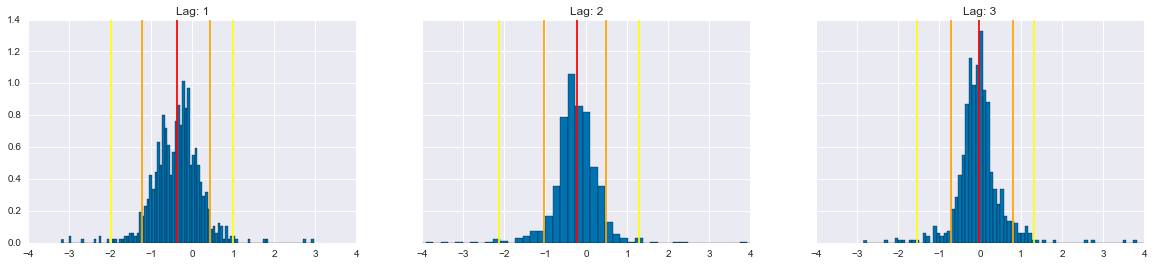

In [11]:
fig, axs = plt.subplots(1,3,figsize=(20,4), sharex=True, sharey=True)
print('Average Coefficients: \n{}'.format(filtered_results.mean()))
for i, ax in enumerate(axs.flat):
    ax.hist(filtered_results['el'+str(i+1)], bins=100, normed=True)
    ax.set_xlim([-8,8])
    ax.set_title('Lag: {}'.format(i+1))
    ax.axvline(filtered_results['el'+str(i+1)].mean(), c='r')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 5), c='orange')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 95), c='orange')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 1), c='yellow')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 99), c='yellow')
    
plt.savefig('../reports/figures/pca_balanced_earthquake_coefficients_distribution.png')
plt.xlim([-4,4])
plt.show()

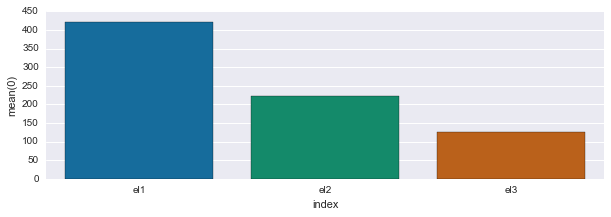

In [10]:
win_counts = filtered_results.apply(lambda r: r.argmin(), axis=1).value_counts().reset_index()
plt.figure(figsize=(10,3))
sns.barplot(x="index", y=0, data=win_counts)
plt.savefig('../reports/figures/pca_balanced_earthquake_coefficients_winning_lag.png')
plt.show()